In [8]:
import h5py
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R

from mimicplay.scripts.aloha_process.simarUtils import (
    cam_frame_to_cam_pixels,
    draw_dot_on_frame,
    general_unnorm,
    miniviewer,
    nds,
    WIDE_LENS_ROBOT_LEFT_K,
    EXTRINSICS,
    ee_pose_to_cam_frame,
    AlohaFK,
)

import matplotlib.pyplot as plt

import torch
import torchvision

In [13]:
#Dataset
data = h5py.File("/coc/flash7/datasets/egoplay/_DEBUG/IKRotationv2/forward/converted/IKROT_forward_normal.hdf5", "r")
nds(data)

dict with keys:  <KeysViewHDF5 ['data', 'mask']>
data: dict with keys:  <KeysViewHDF5 ['demo_0']>
	demo_0: dict with keys:  <KeysViewHDF5 ['actions_xyz', 'actions_xyz_act', 'obs']>
		actions_xyz: (263, 10, 3)
		actions_xyz_act: (263, 100, 3)
		obs: dict with keys:  <KeysViewHDF5 ['ee_pose', 'ee_rot', 'front_img_1', 'palm_normal', 'slam_left_img', 'slam_right_img', 'wrist_normal', 'wrist_pose']>
			ee_pose: (263, 3)
			ee_rot: (263, 4)
			front_img_1: (263, 480, 640, 3)
			palm_normal: (263, 1, 3)
			slam_left_img: (300, 480, 640)
			slam_right_img: (300, 480, 640)
			wrist_normal: (263, 1, 3)
			wrist_pose: (263, 1, 3)
mask: dict with keys:  <KeysViewHDF5 ['train', 'valid']>
	train: (0,)
	valid: (1,)


In [15]:
def plot_axes_on_frame(frame, ee_pose, ee_rot, intrinsics, scale=0.1):
    """
    frame : camera img
    ee_pose : cartesian pose
    ee_rot : rotation quat
    intrinsics : intrinsics
    """
    # Convert quaternion to rotation matrix
    rotation_matrix = R.from_quat(ee_rot).as_matrix()

    origin = ee_pose
    x_axis = origin + scale * rotation_matrix @ np.array([1, 0, 0])
    y_axis = origin + scale * rotation_matrix @ np.array([0, 1, 0])
    z_axis = origin + scale * rotation_matrix @ np.array([0, 0, 1])

    axes_3d = np.vstack([origin, x_axis, y_axis, z_axis])

    axes_2d = cam_frame_to_cam_pixels(axes_3d, intrinsics)

    origin_2d = tuple(axes_2d[0][:2].astype(int))
    x_axis_2d = tuple(axes_2d[1][:2].astype(int))
    y_axis_2d = tuple(axes_2d[2][:2].astype(int))
    z_axis_2d = tuple(axes_2d[3][:2].astype(int))

    frame = cv2.line(frame, origin_2d, x_axis_2d, (0, 0, 255), 2)  # R
    frame = cv2.line(frame, origin_2d, y_axis_2d, (0, 255, 0), 2)  # G
    frame = cv2.line(frame, origin_2d, z_axis_2d, (255, 0, 0), 2)  # B

    return frame

In [31]:
def plot_normals_on_frame(frame, ee_pose, wrist_pose, palm_normal, wrist_normal, intrinsics, scale=0.1):
    wrist_end = wrist_pose + scale * wrist_normal
    wrist_normal_3d = np.vstack([wrist_pose, wrist_end])
    wrist_normal_2d = cam_frame_to_cam_pixels(wrist_normal_3d, intrinsics)

    palm_end = ee_pose + scale * palm_normal
    palm_normal_3d = np.vstack([ee_pose, palm_end])
    palm_normal_2d = cam_frame_to_cam_pixels(palm_normal_3d, intrinsics)


    wrist_start_2d = tuple(wrist_normal_2d[0][:2].astype(int))
    wrist_end_2d = tuple(wrist_normal_2d[1][:2].astype(int))

    palm_start_2d = tuple(palm_normal_2d[0][:2].astype(int))
    palm_end_2d = tuple(palm_normal_2d[1][:2].astype(int))

    frame = cv2.line(frame, wrist_start_2d, wrist_end_2d, (255, 165, 0), 2)  # Wrist normal
    frame = cv2.line(frame, palm_start_2d, palm_end_2d, (153,50,204), 2)  # Palm normal

    return frame


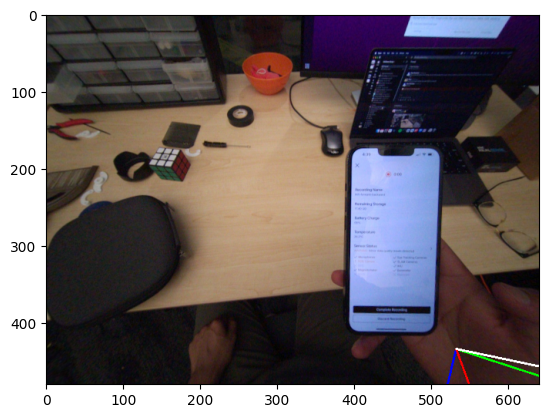

In [25]:
demo = "demo_0"
ee_pose = data[f"data/{demo}/obs/ee_pose"]
ee_rot = data[f"data/{demo}/obs/ee_rot"]
wrist_pose = data[f"data/{demo}/obs/wrist_pose"]
wrist_normal = data[f"data/{demo}/obs/wrist_normal"]
palm_normal = data[f"data/{demo}/obs/wrist_normal"]
front_img_1 = data[f"data/{demo}/obs/front_img_1"]

T = 30

frame_with_axes = plot_axes_on_frame(
    front_img_1[T], 
    ee_pose[T], 
    ee_rot[T],
    intrinsics=WIDE_LENS_ROBOT_LEFT_K
)

frame_with_normals = plot_normals_on_frame(
    frame_with_axes, 
    ee_pose[T], 
    wrist_pose[T],
    palm_normal[T],
    wrist_normal[T],
    intrinsics=WIDE_LENS_ROBOT_LEFT_K
)

plt.imshow(frame_with_axes)

In [32]:
images = []
for demo in list(data["data"].keys()):
    ee_pose = data[f"data/{demo}/obs/ee_pose"]
    ee_rot = data[f"data/{demo}/obs/ee_rot"]
    wrist_pose = data[f"data/{demo}/obs/wrist_pose"]
    wrist_normal = data[f"data/{demo}/obs/wrist_normal"]
    palm_normal = data[f"data/{demo}/obs/wrist_normal"]
    front_img_1 = data[f"data/{demo}/obs/front_img_1"]
    for T in range(len(data[f"data/{demo}/obs/ee_pose"])):
        
        frame_with_axes = plot_axes_on_frame(
            front_img_1[T], 
            ee_pose[T], 
            ee_rot[T], 
            intrinsics=WIDE_LENS_ROBOT_LEFT_K
        )

        frame_with_normals = plot_normals_on_frame(
            frame_with_axes, 
            ee_pose[T], 
            wrist_pose[T],
            palm_normal[T],
            wrist_normal[T],
            intrinsics=WIDE_LENS_ROBOT_LEFT_K
        )

        images.append(frame_with_normals)

images = torch.from_numpy(np.array(images))
# make video via torchvision
torchvision.io.write_video(f"forward_normal.mp4", images, fps=30)